In [ ]:
4!pip install pronouncing
!pip install markovify
!pip install git+https://github.com/autonomio/talos@1.0

import pronouncing
import markovify
import re
import random
import numpy as np
import os
import tensorflow.keras
import talos

from talos.model.early_stopper import early_stopper
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.optimizers import RMSprop, Adam, SGD


def create_network(x_train,y_train,x_val,y_val, params):
  model = Sequential()
  model.add(CuDNNLSTM(4, input_shape=(2, 2), return_sequences=True))
  for i in range(params['depths']-1):
    model.add(CuDNNLSTM(params['neurons'], return_sequences=True))
    model.add(Dropout(params['dropout']))
  model.add(CuDNNLSTM(2, return_sequences=True))
  model.summary()
  model.compile(loss=params['losses'],optimizer=params['optimizer'])
  out = model.fit(np.array(x_data),np.array(x_data), batch_size=params['batch_size'], epochs=params['epochs'], callbacks=[early_stopper(params['epochs'], monitor="loss", mode=[0.0001,5])])
  return out, model


def markov(text_file):
  read = open(text_file, "r", encoding='utf-8').read().lower()
  text_model = markovify.NewlineText(read)
  return text_model

def syllables(line):
  count = 0
  for word in line.split(" "):
    if len(word) == 0:
      continue
    vowels = 'aeiouy'
    # word = word.lower().strip(".:;?!")
    word = word.lower().strip("!@#$%^&*()_+-={}[];:,.<>/?")
    if len(word) == 0:
        continue

    if word[0] in vowels:
      count +=1
    for index in range(1,len(word)):
      if word[index] in vowels and word[index-1] not in vowels:
        count +=1
    if word.endswith('e'):
      count -= 1
    if word.endswith('le'):
      count+=1
    if count == 0:
      count +=1

  return count / maxsyllables

def rhymeindex(lyrics):
  if str(artist) + ".rhymes" in os.listdir(".") and train_mode == False:
    print ("loading saved rhymes from " + str(artist) + ".rhymes")
    return open(str(artist) + ".rhymes", "r",encoding='utf-8').read().split("\n")
  else:
    rhyme_master_list = []
    print ("Building list of rhymes:")
    for i in lyrics:
      word = re.sub(r"\W+", '', i.split(" ")[-1]).lower()
      rhymeslist = pronouncing.rhymes(word)
      rhymeslistends = []
      for i in rhymeslist:
        rhymeslistends.append(i[-2:])
      try:
        rhymescheme = max(set(rhymeslistends), key=rhymeslistends.count)
      except Exception:
        rhymescheme = word[-2:]
      rhyme_master_list.append(rhymescheme)
    rhyme_master_list = list(set(rhyme_master_list))
    reverselist = [x[::-1] for x in rhyme_master_list]
    reverselist = sorted(reverselist)
    rhymelist = [x[::-1] for x in reverselist]
    print("List of Sorted 2-Letter Rhyme Ends:")
    print(rhymelist)
    f = open(str(artist) + ".rhymes", "w", encoding='utf-8')
    f.write("\n".join(rhymelist))
    f.close()
    return rhymelist

def rhyme(line, rhyme_list):
  word = re.sub(r"\W+", '', line.split(" ")[-1]).lower()
  rhymeslist = pronouncing.rhymes(word)
  rhymeslistends = []
  for i in rhymeslist:
    rhymeslistends.append(i[-2:])
  try:
    rhymescheme = max(set(rhymeslistends), key=rhymeslistends.count)
  except Exception:
    rhymescheme = word[-2:]
  try:
    float_rhyme = rhyme_list.index(rhymescheme)
    float_rhyme = float_rhyme / float(len(rhyme_list))
    return float_rhyme
  except Exception:
    float_rhyme = float(np.random.random_sample())
    return float_rhyme

def split_lyrics_file(text_file):
  text = open(text_file, encoding='utf-8').read()
  text = text.split("\n")
  while "" in text:
    text.remove("")
  return text


def generate_lyrics(text_model, text_file):
  bars = []
  last_words = []
  lyriclength = int(np.random.normal(420, 85))
  count = 0
  markov_model = markov(text_file)

  while len(bars) < lyriclength / 9 and count < lyriclength * 2:
    bar = markov_model.make_sentence(max_overlap_ratio = .49, tries=100)
    if type(bar) != type(None) and syllables(bar) < 1:
      def get_last_word(bar):
        last_word = bar.split(" ")[-1]
        if last_word[-1] in "!.?,":
          last_word = last_word[:-1]
        return last_word
      last_word = get_last_word(bar)
      if bar not in bars and last_words.count(last_word) < 3:
        bars.append(bar)
        last_words.append(last_word)
        count += 1
  return bars

def build_dataset(lines, rhyme_list):
  dataset = []
  line_list = []
  for line in lines:
    line_list = [line, syllables(line), rhyme(line, rhyme_list)]
    dataset.append(line_list)
  x_data = []
  y_data = []
  for i in range(len(dataset) - 3):
    line1 = dataset[i    ][1:]
    line2 = dataset[i + 1][1:]
    line3 = dataset[i + 2][1:]
    line4 = dataset[i + 3][1:]
    x = [line1[0], line1[1], line2[0], line2[1]]
    x = np.array(x)
    x = x.reshape(2,2)
    x_data.append(x)
    y = [line3[0], line3[1], line4[0], line4[1]]
    y = np.array(y)
    y = y.reshape(2,2)
    y_data.append(y)
  x_data = np.array(x_data)
  y_data = np.array(y_data)
  return x_data, y_data

def compose_rap(lines, rhyme_list, lyrics_file, model):
  rap_vectors = []
  human_lyrics = split_lyrics_file(lyrics_file)
  initial_index = random.choice(range(len(human_lyrics) - 1))
  initial_lines = human_lyrics[initial_index:initial_index + 2]
  starting_input = []
  for line in initial_lines:
    starting_input.append([syllables(line), rhyme(line, rhyme_list)])
  starting_vectors = model.predict(np.array([starting_input]).flatten().reshape(1, 2, 2))
  rap_vectors.append(starting_vectors)
  for i in range(100):
    rap_vectors.append(model.predict(np.array([rap_vectors[-1]]).flatten().reshape(1, 2, 2)))
  return rap_vectors

def vectors_into_song(vectors, generated_lyrics, rhyme_list):
  print("\n\n")
  print("Writing verse:")
  print("\n\n")
  def last_word_compare(rap, line2):
    penalty = 0
    for line1 in rap:
      word1 = line1.split(" ")[-1]
      word2 = line2.split(" ")[-1]
      while word1[-1] in "?!,. ":
        word1 = word1[:-1]
      while word2[-1] in "?!,. ":
        word2 = word2[:-1]
      if word1 == word2:
        penalty += 0.2
    return penalty

  def calculate_score(vector_half, syllables, rhyme, penalty):
    desired_syllables = vector_half[0]
    desired_rhyme = vector_half[1]
    desired_syllables = desired_syllables * maxsyllables
    desired_rhyme = desired_rhyme * len(rhyme_list)
    score = 1.0 - abs(float(desired_syllables) - float(syllables)) + abs(float(desired_rhyme) - float(rhyme)) - penalty
    return score
  dataset = []
  for line in generated_lyrics:
    line_list = [line, syllables(line), rhyme(line, rhyme_list)]
    dataset.append(line_list)
  rap = []
  vector_halves = []
  for vector in vectors:
    vector_halves.append(list(vector[0][0]))
    vector_halves.append(list(vector[0][1]))
  for vector in vector_halves:
    scorelist = []
    for item in dataset:
      line = item[0]
      if len(rap) != 0:
        penalty = last_word_compare(rap, line)
      else:
        penalty = 0
      total_score = calculate_score(vector, item[1], item[2], penalty)
      score_entry = [line, total_score]
      scorelist.append(score_entry)
    fixed_score_list = [0]
    for score in scorelist:
      fixed_score_list.append(float(score[1]))
    max_score = max(fixed_score_list)
    for item in scorelist:
      if item[1] == max_score:
        rap.append(item[0])
        print (str(item[0]))
        for i in dataset:
          if item[0] == i[0]:
            dataset.remove(i)
            break
        break
  return rap

def train(x_data, y_data, model):
  model.fit(np.array(x_data), np.array(y_data),
        batch_size=params['batch_size'],
        epochs=params['epochs'],
        verbose=1)
  model.save_weights(artist + ".rap")

def main(depth, train_mode):
  model = create_network(depth)
  text_model = markov(input_file)
  if train_mode == True:
    bars = split_lyrics_file(input_file)
  if train_mode == False:
    bars = generate_lyrics(text_model, input_file)
  rhyme_list = rhymeindex(bars)
  if train_mode == True:
    x_data, y_data = build_dataset(bars, rhyme_list)
    train(x_data, y_data, model)
  if train_mode == False:
    vectors = compose_rap(bars, rhyme_list, input_file, model)
    rap = vectors_into_song(vectors, bars, rhyme_list)
    f = open(output_file, "w", encoding='utf-8')
    for bar in rap:
      f.write(bar)
      f.write("\n")


depth = 2
maxsyllables = 8
artist = "artist"
input_file = "lyrics_input.txt"

p_final = {'batch_size': [5, 10, 20, 50],
     'depths': [2,3],
     'epochs': [20,40,80],
     'dropout':[0, 0.1, 0.2, 0.3],
     'neurons':[8,16,32,64],
     'optimizer': ["Adam", "RMSprop"],
     'losses': ["categorical_crossentropy"]}

p_detail = {'batch_size': [25, 50],
     'depths': [2,3],
     'epochs': [20],
     'dropout':[0],
     'neurons':[4],
     'optimizer': ["Adam", "RMSprop"],
     'losses': ["categorical_crossentropy"]}

train_mode = True
barz = split_lyrics_file(input_file)
x_data, y_data = build_dataset(barz, rhymeindex(barz))


# train_mode = True
# main(depth, train_mode)
#
# train_mode = False
# main(depth, train_mode)


  Cloning https://github.com/autonomio/talos (to revision 1.0) to /tmp/pip-req-build-qk0vj14u
  Running command git clone -q https://github.com/autonomio/talos /tmp/pip-req-build-qk0vj14u
  Running command git checkout -b 1.0 --track origin/1.0
  Switched to a new branch '1.0'
  Branch '1.0' set up to track remote branch '1.0' from 'origin'.
  Created wheel for talos: filename=talos-1.0-cp36-none-any.whl size=53701 sha256=18f09e39de994f18d32aacfb4a08b50c5b5e2f8fb2fa866f13116f4596b62fa6
  Stored in directory: /tmp/pip-ephem-wheel-cache-6971_ucd/wheels/9f/14/d1/e58012a97c43cf2148959890b171f49e4a5e1c82a9946b2c22
Successfully built talos
Building list of rhymes:
List of Sorted 2-Letter Rhyme Ends:
['', "s'", '10', '20', '40', '80', '71', '2', '32', '82', '92', '3', '03', '33', '93', 't3', '04', '14', '24', '44', '74', '5', '05', '45', '6', '46', '56', '96', '7', '09', 'a', 'aa', 'ba', 'ca', 'da', 'ea', 'ga', 'ha', 'ia', 'ka', 'la', 'ma', 'na', 'ra', 'sa', 'ta', 'ua', 'va', 'ya', 'za', 'ía'

In [ ]:
# gpu_options = tensorflow.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.5)
# tensorflow.keras.backend.set_session(tensorflow.Session(config=tensorflow.ConfigProto(gpu_options=gpu_options)))


t = talos.Scan(x=x_data, y=y_data,
               model=create_network, 
               fraction_limit=1.0, 
               params=p_detail, 
               experiment_name='detail_experiment',
               print_params=True,
               clear_session=True)

  0%|          | 0/8 [00:00<?, ?it/s]

{'batch_size': 50, 'depths': 2, 'dropout': 0, 'epochs': 20, 'losses': 'categorical_crossentropy', 'neurons': 4, 'optimizer': 'RMSprop'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 2, 4)              128       
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 2, 4)              160       
_________________________________________________________________
dropout (Dropout)            (None, 2, 4)              0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 2, 2)              64        
Total params: 352
Trainable params: 352
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
296/296 [==============================] - 6s 20ms/step - loss: 1.0707
Epoch 2/20
296/296 [==================

 12%|█▎        | 1/8 [00:42<04:57, 42.48s/it]

{'batch_size': 50, 'depths': 3, 'dropout': 0, 'epochs': 20, 'losses': 'categorical_crossentropy', 'neurons': 4, 'optimizer': 'RMSprop'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 2, 4)              128       
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 2, 4)              160       
_________________________________________________________________
dropout (Dropout)            (None, 2, 4)              0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 2, 4)              160       
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 4)              0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 2, 2)           

 25%|██▌       | 2/8 [00:57<03:25, 34.22s/it]

{'batch_size': 25, 'depths': 2, 'dropout': 0, 'epochs': 20, 'losses': 'categorical_crossentropy', 'neurons': 4, 'optimizer': 'Adam'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 2, 4)              128       
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 2, 4)              160       
_________________________________________________________________
dropout (Dropout)            (None, 2, 4)              0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 2, 2)              64        
Total params: 352
Trainable params: 352
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
591/591 [==============================] - 3s 5ms/step - loss: 0.9981
Epoch 2/20
591/591 [======================

 38%|███▊      | 3/8 [01:59<03:32, 42.51s/it]

{'batch_size': 25, 'depths': 2, 'dropout': 0, 'epochs': 20, 'losses': 'categorical_crossentropy', 'neurons': 4, 'optimizer': 'RMSprop'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 2, 4)              128       
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 2, 4)              160       
_________________________________________________________________
dropout (Dropout)            (None, 2, 4)              0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 2, 2)              64        
Total params: 352
Trainable params: 352
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
591/591 [==============================] - 3s 5ms/step - loss: 11.1437
Epoch 2/20
591/591 [==================

 50%|█████     | 4/8 [03:00<03:11, 47.99s/it]

{'batch_size': 50, 'depths': 2, 'dropout': 0, 'epochs': 20, 'losses': 'categorical_crossentropy', 'neurons': 4, 'optimizer': 'Adam'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 2, 4)              128       
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 2, 4)              160       
_________________________________________________________________
dropout (Dropout)            (None, 2, 4)              0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 2, 2)              64        
Total params: 352
Trainable params: 352
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
296/296 [==============================] - 1s 5ms/step - loss: 1.1009
Epoch 2/20
296/296 [======================

 62%|██████▎   | 5/8 [03:29<02:07, 42.44s/it]

{'batch_size': 50, 'depths': 3, 'dropout': 0, 'epochs': 20, 'losses': 'categorical_crossentropy', 'neurons': 4, 'optimizer': 'Adam'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 2, 4)              128       
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 2, 4)              160       
_________________________________________________________________
dropout (Dropout)            (None, 2, 4)              0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 2, 4)              160       
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 4)              0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 2, 2)              

 75%|███████▌  | 6/8 [04:05<01:20, 40.45s/it]

{'batch_size': 25, 'depths': 3, 'dropout': 0, 'epochs': 20, 'losses': 'categorical_crossentropy', 'neurons': 4, 'optimizer': 'RMSprop'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 2, 4)              128       
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 2, 4)              160       
_________________________________________________________________
dropout (Dropout)            (None, 2, 4)              0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 2, 4)              160       
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 4)              0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 2, 2)           

 88%|████████▊ | 7/8 [05:20<00:51, 51.00s/it]

{'batch_size': 25, 'depths': 3, 'dropout': 0, 'epochs': 20, 'losses': 'categorical_crossentropy', 'neurons': 4, 'optimizer': 'Adam'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 2, 4)              128       
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 2, 4)              160       
_________________________________________________________________
dropout (Dropout)            (None, 2, 4)              0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 2, 4)              160       
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 4)              0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 2, 2)              

100%|██████████| 8/8 [05:47<00:00, 43.39s/it]


In [ ]:
t.data

,start,end,duration,round_epochs,loss,batch_size,depths,dropout,epochs,losses,neurons,optimizer
0,10/30/20-200609,10/30/20-200651,42.342990,20,8.682181e-01,50,2,0,20,categorical_crossentropy,4,RMSprop
1,10/30/20-200651,10/30/20-200706,14.767235,7,1.890840e-07,50,3,0,20,categorical_crossentropy,4,RMSprop
2,10/30/20-200706,10/30/20-200808,61.654817,20,8.775170e-01,25,2,0,20,categorical_crossentropy,4,Adam
3,10/30/20-200808,10/30/20-200908,60.594052,20,8.680808e-01,25,2,0,20,categorical_crossentropy,4,RMSprop
4,10/30/20-200909,10/30/20-200938,29.280663,20,8.762554e-01,50,2,0,20,categorical_crossentropy,4,Adam
5,10/30/20-200938,10/30/20-201014,35.637344,20,8.681201e-01,50,3,0,20,categorical_crossentropy,4,Adam
6,10/30/20-201014,10/30/20-201129,75.406008,20,8.685599e-01,25,3,0,20,categorical_crossentropy,4,RMSprop
7,10/30/20-201130,10/30/20-201156,25.950813,7,7.683535e+00,25,3,0,20,categorical_crossentropy,4,Adam


In [ ]:
t.details

experiment_name        detail_experiment
random_method           uniform_mersenne
reduction_method                    None
reduction_interval                    50
reduction_window                      20
reduction_threshold                  0.2
reduction_metric                 val_acc
complete_time             10/30/20/20:11
x_shape                    (14770, 2, 2)
y_shape                    (14770, 2, 2)
dtype: object

In [ ]:
scan_analysis = talos.Analyze(t)
scan_analysis.low('loss')


1.890839769203012e-07

In [ ]:
t.best_model(metric='loss', asc=True)
# Make a report on the scan
r = talos.Reporting(t)
# Show the models
display(r.data)

,start,end,duration,round_epochs,loss,batch_size,depths,dropout,epochs,losses,neurons,optimizer
0,10/30/20-200609,10/30/20-200651,42.342990,20,8.682181e-01,50,2,0,20,categorical_crossentropy,4,RMSprop
1,10/30/20-200651,10/30/20-200706,14.767235,7,1.890840e-07,50,3,0,20,categorical_crossentropy,4,RMSprop
2,10/30/20-200706,10/30/20-200808,61.654817,20,8.775170e-01,25,2,0,20,categorical_crossentropy,4,Adam
3,10/30/20-200808,10/30/20-200908,60.594052,20,8.680808e-01,25,2,0,20,categorical_crossentropy,4,RMSprop
4,10/30/20-200909,10/30/20-200938,29.280663,20,8.762554e-01,50,2,0,20,categorical_crossentropy,4,Adam
5,10/30/20-200938,10/30/20-201014,35.637344,20,8.681201e-01,50,3,0,20,categorical_crossentropy,4,Adam
6,10/30/20-201014,10/30/20-201129,75.406008,20,8.685599e-01,25,3,0,20,categorical_crossentropy,4,RMSprop
7,10/30/20-201130,10/30/20-201156,25.950813,7,7.683535e+00,25,3,0,20,categorical_crossentropy,4,Adam


In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)  
r.data.sort_values('loss').to_csv("scanresults.csv")

In [ ]:
t.params

{'batch_size': [25, 50],
 'depths': [2, 3],
 'dropout': [0],
 'epochs': [20],
 'losses': ['categorical_crossentropy'],
 'neurons': [4],
 'optimizer': ['Adam', 'RMSprop']}

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


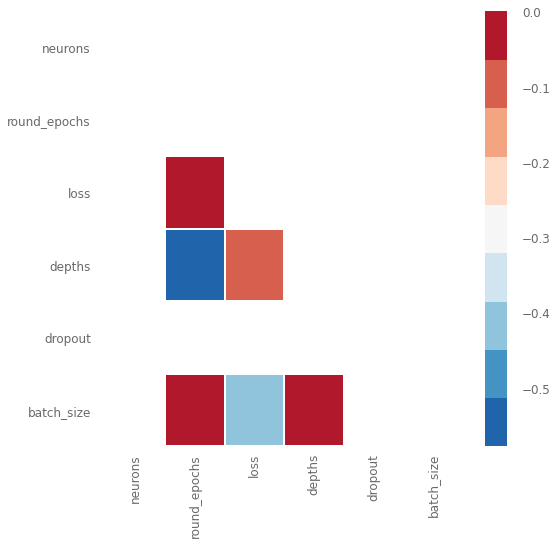

In [ ]:
scan_analysis.plot_corr('loss',['epochs','duration'],color_grades=9)

In [ ]:
# get the best paramaters
print(scan_analysis.best_params('loss',['epochs','duration','start','end'], ascending=True))
# get correlation for hyperparameters against a metric
print(scan_analysis.correlate('loss',['epochs','duration','start','end']))

[[4 'RMSprop' 7 'categorical_crossentropy' 3 0 50 0]
 [4 'RMSprop' 20 'categorical_crossentropy' 2 0 25 1]
 [4 'Adam' 20 'categorical_crossentropy' 3 0 50 2]
 [4 'RMSprop' 20 'categorical_crossentropy' 2 0 50 3]
 [4 'RMSprop' 20 'categorical_crossentropy' 3 0 25 4]
 [4 'Adam' 20 'categorical_crossentropy' 2 0 50 5]
 [4 'Adam' 20 'categorical_crossentropy' 2 0 25 6]
 [4 'Adam' 7 'categorical_crossentropy' 3 0 25 7]]
round_epochs   -0.556416
batch_size     -0.415536
depths          0.320645
dropout              NaN
neurons              NaN
Name: loss, dtype: float64


In [ ]:
r.table('loss', ascending=True)

,neurons,end,epochs,optimizer,duration,round_epochs,losses,loss,depths,dropout,batch_size,start
1,4,10/30/20-200706,20,RMSprop,14.767235,7,categorical_crossentropy,1.890840e-07,3,0,50,10/30/20-200651
3,4,10/30/20-200908,20,RMSprop,60.594052,20,categorical_crossentropy,8.680808e-01,2,0,25,10/30/20-200808
5,4,10/30/20-201014,20,Adam,35.637344,20,categorical_crossentropy,8.681201e-01,3,0,50,10/30/20-200938
0,4,10/30/20-200651,20,RMSprop,42.342990,20,categorical_crossentropy,8.682181e-01,2,0,50,10/30/20-200609
6,4,10/30/20-201129,20,RMSprop,75.406008,20,categorical_crossentropy,8.685599e-01,3,0,25,10/30/20-201014
4,4,10/30/20-200938,20,Adam,29.280663,20,categorical_crossentropy,8.762554e-01,2,0,50,10/30/20-200909
2,4,10/30/20-200808,20,Adam,61.654817,20,categorical_crossentropy,8.775170e-01,2,0,25,10/30/20-200706
7,4,10/30/20-201156,20,Adam,25.950813,7,categorical_crossentropy,7.683535e+00,3,0,25,10/30/20-201130


In [ ]:
display(r.data.loc[r.data['loss'] == np.min(r.data['loss'])])
#lowest loss

# just the index:
# r.data.loc[r.data[column] == np.min(r.data[column])].index.values[0]

,start,end,duration,round_epochs,loss,batch_size,depths,dropout,epochs,losses,neurons,optimizer
1,10/30/20-200651,10/30/20-200706,14.767235,7,1.890840e-07,50,3,0,20,categorical_crossentropy,4,RMSprop
